IMPORT

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_iris
import seaborn as sbn
import random as rng
import math

In [2]:
df = pd.read_csv("ds_salaries.csv")
"""
Beberapa Notes untuk Kolom dataset tersebut adalah: 
1. work_year: Tahun dimana gajinya telah diberikan
2. experience_level: level experience / pengalaman dalam bidang pekerjaan
    field_value: {
        EN: Entry level                 1
        MI: Junior Mid Level            2
        SE: Intermediate Senior Level   3
        EX: Expert Executive Level      4
    }
3. employement_type: Tipe pekerja
    field_value: {
        PT: kerja paruh waktu           4
        FT: kerja fulltime              3
        CT: contract                    2
        FL: Freelance                   1
}
4. job_title: Job Title
5. salary: nilai gaji
6. salary_currency: nilai gaji tersebut dalam mata uang apa
7. salary_in_usd: gaji jika di ubah menjadi mata uang dollar
8. employee_residence: lokasi asal dari pekerja
9. remote_ratio: rasio pekerja bekerja secara jarak jauh
10. company_location: lokasi perusahaan pekerja
11. company_size: ukuran dari perusahaan berdasarkan dari jumlah pekerja di sana
    field_value{
        S: small (x<50),
        M: medium (50<=x<250),
        L: large (x>250),
}
"""

df = df.drop(columns="sam")
df

,num,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
...,...,...,...,...,...,...,...,...,...,...,...,...
602,602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M
603,603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M
604,604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M
605,605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M


<Axes: ylabel='salary_in_usd'>

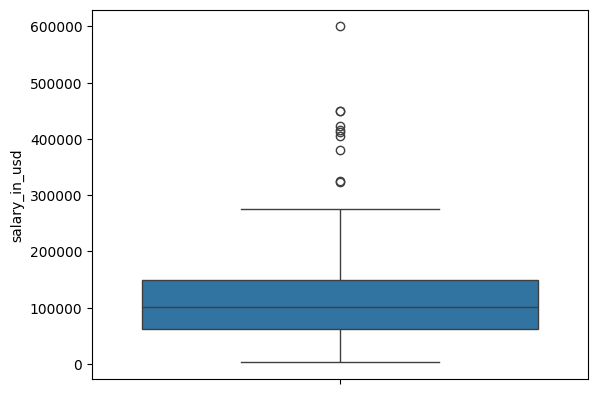

In [3]:
sbn.boxplot(df["salary_in_usd"])

Membersihkan Outlier dan Keseluruhan Data

-68185.0, 280911.0


<Axes: ylabel='salary_in_usd'>

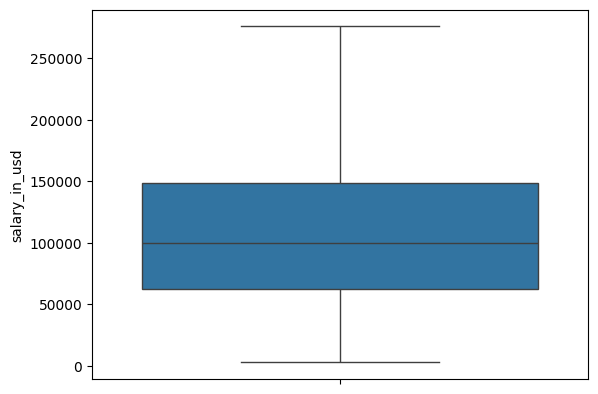

In [4]:
df = df.drop(["salary_currency"], axis=1)

q1 = df["salary_in_usd"].quantile(0.25) # Quartile 1
q3 = df["salary_in_usd"].quantile(0.75) # Quartile 3
iqr = q3-q1 # Inter Quartile Range

low_lim = q1 - 1.5*iqr
hi_lim = q3 + 1.5*iqr

print(f"{low_lim}, {hi_lim}")

for i in range(len(df["salary_in_usd"])):
    if hi_lim < df["salary_in_usd"][i]:
        df = df.drop([i])

sbn.boxplot(df["salary_in_usd"])

In [5]:
df = df.reset_index()

df = df.drop(columns="num")

# Mengubah Kategorikal
df["company_size"] = df["company_size"].apply(lambda x: 1 if x == "S" else x)
df["company_size"] = df["company_size"].apply(lambda x: 2 if x == "M" else x)
df["company_size"] = df["company_size"].apply(lambda x: 3 if x == "L" else x)



df["experience_level"] = df["experience_level"].apply(lambda x: 1 if x == "EN" else x)
df["experience_level"] = df["experience_level"].apply(lambda x: 2 if x == "MI" else x)
df["experience_level"] = df["experience_level"].apply(lambda x: 3 if x == "SE" else x)
df["experience_level"] = df["experience_level"].apply(lambda x: 4 if x == "EX" else x)

df["employment_type"] = df["employment_type"].apply(lambda x: 4 if x == "FT" else x)
df["employment_type"] = df["employment_type"].apply(lambda x: 3 if x == "PT" else x)
df["employment_type"] = df["employment_type"].apply(lambda x: 2 if x == "CT" else x)
df["employment_type"] = df["employment_type"].apply(lambda x: 1 if x == "FL" else x)

df.describe()

,index,work_year,experience_level,employment_type,salary,salary_in_usd,remote_ratio,company_size
count,597.000000,597.000000,597.000000,597.000000,5.970000e+02,597.000000,597.000000,597.000000
mean,304.095477,2021.412060,2.390285,3.949749,3.224171e+05,107168.855946,70.686767,2.182580
std,174.888716,0.688634,0.779416,0.318587,1.557181e+06,58555.516292,40.797800,0.651661
min,0.000000,2020.000000,1.000000,1.000000,4.000000e+03,2859.000000,0.000000,1.000000
25%,153.000000,2021.000000,2.000000,4.000000,6.999900e+04,62649.000000,50.000000,2.000000
50%,305.000000,2022.000000,3.000000,4.000000,1.129000e+05,100000.000000,100.000000,2.000000
75%,454.000000,2022.000000,3.000000,4.000000,1.600000e+05,148261.000000,100.000000,3.000000
max,606.000000,2022.000000,4.000000,4.000000,3.040000e+07,276000.000000,100.000000,3.000000


Data Splitting

In [12]:
dataset = np.log1p(df[["salary_in_usd"]].values)

train_size = round(len(df["salary_in_usd"]) - len(df["salary_in_usd"])*0.75)


data_train, data_test = dataset[0:train_size,:], dataset[train_size:len(dataset), :]

print(data_train.shape)
print(data_test.shape)

(149, 1)
(448, 1)


In [13]:
def create_dataset(data, look_back = 1):
    datax, datay = [], []
    for i in range(len(data) - look_back - 1):
        a = data[i:(i+look_back), 0]
        datax.append(a)
        datay.append(data[i+ look_back, 0])
    return np.array(datax), np.array(datay)

once = 1
trainX, trainY = create_dataset(data_train, once)
testX, testY = create_dataset(data_test, once)


print(f"shape: trX: {trainX.shape}, trY: {trainY.shape}, teX: {testX.shape}, teY: {trainY.shape}")

shape: trX: (147, 1), trY: (147,), teX: (446, 1), teY: (147,)


In [14]:
trainX = np.reshape(trainX, (trainX.shape[0],1,trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0],1,testX.shape[1]))

print(testX.shape)
print(trainX.shape)
print("\n")
print(testY.shape)
print(trainY.shape)

(446, 1, 1)
(147, 1, 1)


(446,)
(147,)


Implementasi Machine Learning

In [15]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error

In [16]:
#LSTM

model = Sequential()
model.add(LSTM(4, input_shape=(1, once)))
model.add(Dense(1))

model.compile(loss= 'mean_squared_error', optimizer="adam")
model.fit(trainX,trainY,epochs=500, batch_size=32, verbose=2)

Epoch 1/500
5/5 - 1s - loss: 125.3471 - 1s/epoch - 253ms/step
Epoch 2/500
5/5 - 0s - loss: 124.9921 - 8ms/epoch - 2ms/step
Epoch 3/500
5/5 - 0s - loss: 124.6586 - 16ms/epoch - 3ms/step
Epoch 4/500
5/5 - 0s - loss: 124.3385 - 9ms/epoch - 2ms/step
Epoch 5/500
5/5 - 0s - loss: 124.0235 - 16ms/epoch - 3ms/step
Epoch 6/500
5/5 - 0s - loss: 123.7034 - 8ms/epoch - 2ms/step
Epoch 7/500
5/5 - 0s - loss: 123.3617 - 17ms/epoch - 3ms/step
Epoch 8/500
5/5 - 0s - loss: 122.9983 - 9ms/epoch - 2ms/step
Epoch 9/500
5/5 - 0s - loss: 122.6108 - 8ms/epoch - 2ms/step
Epoch 10/500
5/5 - 0s - loss: 122.1963 - 16ms/epoch - 3ms/step
Epoch 11/500
5/5 - 0s - loss: 121.7585 - 8ms/epoch - 2ms/step
Epoch 12/500
5/5 - 0s - loss: 121.2946 - 8ms/epoch - 2ms/step
Epoch 13/500
5/5 - 0s - loss: 120.8084 - 8ms/epoch - 2ms/step
Epoch 14/500
5/5 - 0s - loss: 120.2998 - 8ms/epoch - 2ms/step
Epoch 15/500
5/5 - 0s - loss: 119.7673 - 16ms/epoch - 3ms/step
Epoch 16/500
5/5 - 0s - loss: 119.2171 - 17ms/epoch - 3ms/step
Epoch 17/5

In [17]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

train_predict = np.expm1(train_predict)
trainY = np.expm1(trainY)
test_predict = np.expm1(test_predict)
testY = np.expm1(testY)

trainscore = math.sqrt(mean_squared_error(trainY, train_predict[:,0]))
testscore = math.sqrt(mean_squared_error(testY, test_predict[:,0]))

print(f"train: {trainscore}, test: {testscore}")

14/14 [==============================] - 0s 1ms/step
train: 94411.08051780135, test: 110599.00794368256


In [18]:
series = pd.Series(testY)

if testscore < series.std():
    print("Performa model cukup bagus")
    print(f"{testscore} < {series.std()}")
else:
    print("Performa model tidak cukup bagus")
    print(f"{testscore} > {series.std()}")

Performa model tidak cukup bagus
110599.00794368256 > 57102.92618223756


In [25]:
X ,y = load_iris(return_X_y=True)

In [24]:
pipa = Pipeline([
    ("scale", StandardScaler()),
    ("model", RandomForestRegressor())
])

In [26]:
pipa.fit(X, y)

Pipeline(steps=[('scale', StandardScaler()),
                ('model', RandomForestRegressor())])

In [27]:
pipa.predict(X)

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 1.  , 1.11, 1.  , 1.  ,
       1.  , 1.  , 1.07, 1.  , 1.  , 1.01, 1.  , 1.01, 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.02, 1.  , 1.37, 1.  , 1.19, 1.  , 1.  , 1.  , 1.05,
       1.36, 1.  , 1.  , 1.  , 1.  , 1.  , 1.33, 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 2.  , 2.  , 2.  , 2.  , 2.  , 2.  , 1.65, 2.  , 2.  , 2.  ,
       2.  , 1.99, 2.  , 1.98, 2.  , 2.  , 2.  , 2.  , 2.  , 1.7 , 2.  ,
       1.97, 2.  , 1.98, 2.  , 2.  , 1.98, 1.96, 2.  , 1.76, 2.  , 2.  ,
       2.  , 1.84, 1.91, 2.  , 2.  , 2.  , 1.88, 2.  , 2.  , 2.  , 2.  ,
       2.  , 2.  , 2.  , 1.99, 2.  , 2.  , 1.98])